# Logistic Regression Model Analysis
### Analysis of Ezafe Identification Results
*Author: Raha Musavi*

*Matrikelnummer: 08022255354*

*Thesis: Modeling the Presence and the Classification of Ezafe in Middle Persian Nominal Phrases*

*Date: 01 May 2025*

This notebook provides a detailed analysis of the trained Logistic Regression model for identifying the presence of Ezafe in Middle Persian nominal phrases. It covers key evaluation metrics, Receiver Operating Characteristic (ROC) analysis, the learning curve, checks for data integrity, the random label shuffling test, and an analysis of misclassification errors. The structure and content of this notebook align with Sections 5.9 and 5.10 of the thesis, providing the empirical results that support the discussion and conclusions.

<span style="color: red;">**Note on Model Configuration:**.</span> The analysis presented in the following subsections (5.10.1 - 5.10.5) utilizes the final trained Logistic Regression model that includes the one-hot encoded `source_file` feature in its feature set. This corresponds to the model configuration yielding the results presented in Table 11 of the thesis. Other figures and discussions in the thesis (prior to Section 5.11) depict results obtained from earlier iterations of the model development (namely, before the `source_file` feature was added), which results in minor visual or numerical differences compared to the outputs generated by this notebook. The results presented here reflect the final model configuration used for the comprehensive analysis discussed in Section 5.11.

This configuration, including the one-hot encoded `source_file` feature, was ultimately selected as the final model for the detailed analysis presented in the thesis. Its consistent performance across different executions, showing only minor numerical variations (as evidenced by the comparison between various runs), demonstrated robustness. The inclusion of the `source_file` feature, while yielding a slight improvement in accuracy (as discussed in Section 5.11 and shown in Table 11), further enhanced the model's ability to capture subtle textual variations influencing ezafe distribution.


In [ ]:
## Setup and Data Loading

# Import necessary libraries for data manipulation, modeling, evaluation, and visualization.
import pandas as pd
import numpy as np
import joblib # Used for loading the pre-trained model (Section 5.7)
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold # Needed for reproducing the split and calculating the learning curve (Sections 5.9, 5.10.2)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score # Standard evaluation metrics (Sections 5.9, 5.10.1)
from imblearn.over_sampling import RandomOverSampler # Used to reproduce the oversampling step (Section 5.5)
from sklearn.utils import shuffle # Used for the random label shuffling test (Section 5.10.4)
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For enhanced visualizations (e.g., heatmaps)
import os # To check for file existence

# Suppress specific warnings that might arise from libraries (e.g., solver warnings).
import warnings
warnings.filterwarnings("ignore")

# Configure plotting styles for consistency and readability
sns.set_style("whitegrid")
# As per thesis Chapter 5 introduction, LR analysis uses warm-based palettes.
# The 'Reds' colormap used later for the confusion matrix

In [ ]:
# --- Configuration ---
# Define input file paths. These files are generated by the lr_feature_engineering.py and lr_train_evaluate.py scripts.
INPUT_FEATURES_CSV = "lr_final_features.csv" # Contains the features after preprocessing and selection
INPUT_TARGET_CSV = "lr_target.csv"         # Contains the target variable (ezafe_label)
INPUT_MODEL_PATH = "final_logistic_regression_model.pkl" # The saved, trained Logistic Regression model (Table 11)

# Configuration parameters needed to reproduce the specific train/test split and resampling performed during training.
TEST_SIZE = 0.3
RANDOM_STATE = 42

# Configuration for the Learning Curve plot (Section 5.10.2)
# Number of cross-validation folds to use when calculating the learning curve.
CV_FOLDS_LC = 5

# --- Load Data and Trained Model ---
if not os.path.exists(INPUT_FEATURES_CSV) or not os.path.exists(INPUT_TARGET_CSV) or not os.path.exists(INPUT_MODEL_PATH):
    print(f"Error: Required input files not found.")
    print(f"Please ensure '{INPUT_FEATURES_CSV}', '{INPUT_TARGET_CSV}', and '{INPUT_MODEL_PATH}' exist by running previous scripts.")
else:
    # Load the feature set (X) and target variable (y) from CSV files.
    X = pd.read_csv(INPUT_FEATURES_CSV)
    # squeeze() to convert single-column DataFrame to Series for target.
    y = pd.read_csv(INPUT_TARGET_CSV).squeeze() 

    # Load the saved trained Logistic Regression model (Table 11).
    best_model = joblib.load(INPUT_MODEL_PATH)

    print(f"Loaded final features (X) shape: {X.shape}")
    print(f"Loaded target (y) shape: {y.shape}")
    print("Loaded trained Logistic Regression model.")

    # --- Reproduce Train/Test Split and Oversampling ---
    # Apply oversampling to balance the dataset using RandomOverSampler.
    # This creates X_resampled and y_resampled, matching the data shape before the final split in lr_train_evaluate.py.
    #oversampling here affects both train and test set because it is observed that due to the terribly skewed class distribution, the test set is not representative of the training set.
    oversampler = RandomOverSampler(random_state=RANDOM_STATE)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    print(f"\nReproduced resampled data shape: {X_resampled.shape}")
    print(f"Reproduced resampled target distribution:\n{y_resampled.value_counts()}") # Shows counts for class 1 and 2.

    # Split the resampled data into training and test sets.
    # Using stratified splitting is crucial to maintain the class distribution across splits, especially with imbalanced data.
    # This recreates X_train, X_test, y_train, y_test identical to those used in lr_train_evaluate.py.
        X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_resampled 
    )
    print(f"\nReproduced Train data shape: {X_train.shape}")
    print(f"Reproduced Test data shape: {X_test.shape}")



Loaded final features (X) shape: (23234, 62)
Loaded target (y) shape: (23234,)
Loaded trained Logistic Regression model.

Reproduced resampled data shape: (40376, 62)
Reproduced resampled target distribution:
ezafe_label
2    20188
1    20188
Name: count, dtype: int64

Reproduced Train data shape: (28263, 62)
Reproduced Test data shape: (12113, 62)


## 5.9 Results

This section presents the primary evaluation metrics for the optimal Logistic Regression model on the test set (`X_test`, `y_test`), as discussed in Section 5.9. These metrics provide an overall assessment of the model's performance in classifying ezafe presence.

In [20]:
if 'best_model' in locals() and 'X_test' in locals():
    # Make predictions on the test set using the loaded, best-performing model.
    y_pred = best_model.predict(X_test)

    print("--- Test Set Evaluation (Section 5.9) ---")
    # Calculate and print the overall accuracy of the model.
    print("Accuracy:", accuracy_score(y_test, y_pred))
    # Prints the detailed classification report, including precision, recall, and f1-score for each class.
    # This report is referenced in Section 5.9 and provides per-class performance metrics.
    print("Classification Report:\n", classification_report(y_test, y_pred))
else:
    print("Model or test data not loaded. Please check previous cells.")

--- Test Set Evaluation (Section 5.9) ---
Accuracy: 0.9309832411458764
Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.95      0.93      6057
           2       0.95      0.91      0.93      6056

    accuracy                           0.93     12113
   macro avg       0.93      0.93      0.93     12113
weighted avg       0.93      0.93      0.93     12113



### 5.9.1 Confusion Matrix

The confusion matrix is a table that visualizes the performance of a classification model. Each row represents the instances in a true class, while each column represents the instances in a predicted class. It shows the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions on the test set (Section 5.9.1, Figure 15). 

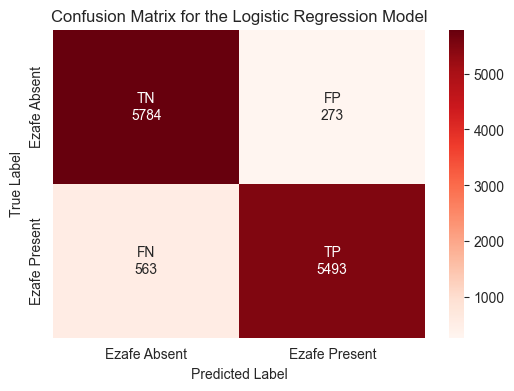


Counts from Confusion Matrix:
True Positives (TP): 5493
False Positives (FP): 273
False Negatives (FN): 563
True Negatives (TN): 5784


In [21]:
if 'y_test' in locals() and 'y_pred' in locals():
    # Generate the confusion matrix using the true and predicted labels from the test set evaluation.
    # The target labels in the thesis confusion matrix plot (Figure 15) are mapped to 'Ezafe Absent' (1) and 'Ezafe Present' (2).
    # I map my numerical labels (1 and 2) back to these string labels for the plot's clarity.
    y_test_mapped = y_test.map({2: 'Ezafe Present', 1: 'Ezafe Absent'}) # Map numerical target (1/2) to string labels as in Figure 15.
    y_pred_mapped = pd.Series(y_pred).map({2: 'Ezafe Present', 1: 'Ezafe Absent'}) # Ensure y_pred is a Series for mapping and apply same mapping.

    # Calculate the confusion matrix array. The order of labels in y_test_mapped determines row/column order.
    # By default, confusion_matrix orders labels alphabetically: ['Ezafe Absent', 'Ezafe Present'].
    conf_matrix = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['Ezafe Absent', 'Ezafe Present']) # Explicitly define labels order for consistency.

    # Extract True Negatives, False Positives, False Negatives, and True Positives from the matrix.
    # The ravel() method flattens the matrix in row-major order: [TN, FP, FN, TP].
    TN, FP, FN, TP = conf_matrix.ravel()

    # Create a labeled matrix to display the counts (TN, FP, FN, TP) directly on the heatmap cells.
    conf_matrix_labeled = np.array([[f'TN\n{TN}', f'FP\n{FP}'],
                                    [f'FN\n{FN}', f'TP\n{TP}']])

    # Display the confusion matrix using a heatmap for visualization (Section 5.9.1, Figure 15 equivalent).
    # Use a warm-based palette as suggested for LR analysis in the thesis (Chapter 5 intro). 'Reds' is a suitable warm palette.
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        conf_matrix, # The numerical confusion matrix.
        annot=conf_matrix_labeled, # The labeled array for displaying counts within cells.
        fmt="", # Use an empty format string for annotations to display text labels correctly.
        cmap="Reds", # Colormap (warm-based palette).
        xticklabels=['Ezafe Absent', 'Ezafe Present'], # Labels for the predicted classes on the x-axis.
        yticklabels=['Ezafe Absent', 'Ezafe Present']  # Labels for the true classes on the y-axis.
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for the Logistic Regression Model")
    # Save the figure (optional, but good for repository documentation)
    # plt.savefig("lr_confusion_matrix.png", bbox_inches='tight')
    plt.show()

    # Print the extracted counts, which are often discussed in the text (Section 5.9.1).
    print("\nCounts from Confusion Matrix:")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Negatives (TN): {TN}")
else:
    print("Test labels (y_test) or predicted labels (y_pred) not defined. Please check previous cells.")

## 5.10 Evaluation of the Model

This section provides a more in-depth evaluation of the Logistic Regression model's performance and generalization capabilities using various metrics and visualizations, as discussed in Section 5.10. This includes the ROC curve, learning curve, correlation analysis, and the random label shuffling test.

### 5.10.1 Receiver Operating Characteristic (ROC)

The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. Plotting the true positive rate against the false positive rate at various threshold settings, the curve demonstrates the model's ability to distinguish between the positive and negative classes. The Area Under the Curve (AUC) provides a single scalar value that summarizes this discriminatory power, ranging from 0 (random classifier) to 1 (perfect classifier) (Section 5.10.1, Figure 16).

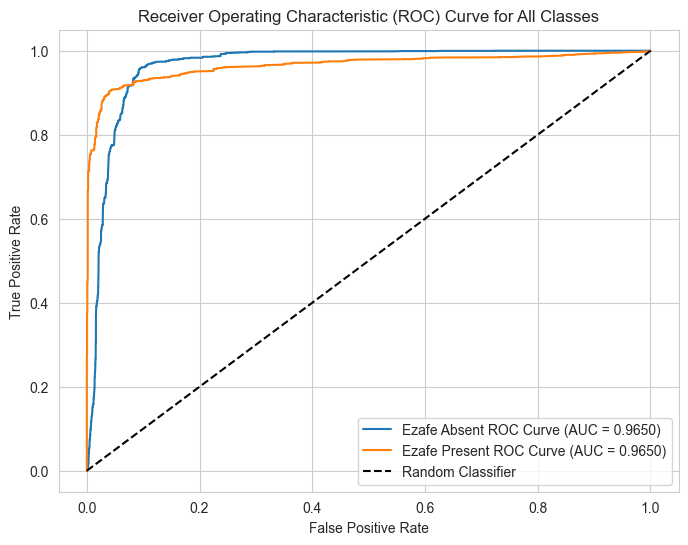


AUC Scores per Class (Section 5.10.1):
  Ezafe Absent: 0.9650
  Ezafe Present: 0.9650


In [ ]:
if 'best_model' in locals() and 'X_test' in locals():
    # Calculate predicted probabilities for the test set.
    # predict_proba returns the probability of belonging to each class for each sample.
    y_prob = best_model.predict_proba(X_test)

    # gets the class labels from the model. These are the unique values the model was trained on (namely, 1 and 2).
    classes = best_model.classes_
    # Map numerical labels to meaningful names for the plot legend, matching the confusion matrix.
    class_names = {1: 'Ezafe Absent', 2: 'Ezafe Present'}

    # Calculate ROC curve points (False Positive Rate, True Positive Rate) and AUC for each class
    # using a one-vs-rest approach, as we have a binary classification problem but the plotting
    # function can be generalized (Section 5.10.1, Figure 16 equivalent).
    fpr = {} # Dictionary to store False Positive Rates for each class.
    tpr = {} # Dictionary to store True Positive Rates for each class.
    roc_auc = {} # Dictionary to store Area Under the Curve for each class.

    for i, class_label in enumerate(classes):
        # Create a binary true label array: 1 if the sample belongs to the current class, 0 otherwise.
        y_true_binary = (y_test == class_label).astype(int)
        # Get the probability scores predicted by the model for this specific class.
        y_score = y_prob[:, i] # Column 'i' corresponds to class classes[i].

        # Calculate the ROC curve points (fp and tp) for this class.
        fpr[class_label], tpr[class_label], _ = roc_curve(y_true_binary, y_score)

        # Calculate the Area Under the ROC Curve (AUC).
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

    # Plot the ROC curves for all classes (Section 5.10.1, Figure 16 equivalent).
    plt.figure(figsize=(8, 6))

    for class_label in classes:
        plt.plot(fpr[class_label], tpr[class_label], label=f'{class_names[class_label]} ROC Curve (AUC = {roc_auc[class_label]:.4f})')

    # Plot the diagonal line representing a random classifier (AUC = 0.5).
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes')
    plt.legend(loc='lower right') # Place legend in the lower right corner.
    plt.grid(True) # Add a grid for readability.
    plt.savefig("lr_roc_curve.png", bbox_inches='tight')
    plt.show()

    # Print the calculated AUC scores per class (Section 5.10.1).
    print("\nAUC Scores per Class (Section 5.10.1):")
    for class_label in classes:
        print(f"  {class_names[class_label]}: {roc_auc[class_label]:.4f}")

else:
    print("Model or test data not loaded. Please check previous cells.")

### 5.10.2 Learning Curve

The learning curve is a plot that shows the performance of a model on both the training and validation sets as a function of the training set size. It is a useful tool for diagnosing whether the model is suffering from high variance (overfitting) or high bias (underfitting). A small gap between training and validation scores as training size increases suggests good generalization, while a large gap indicates overfitting. Low scores on both, even with more data, suggest underfitting (Section 5.10.2, Figure 17).

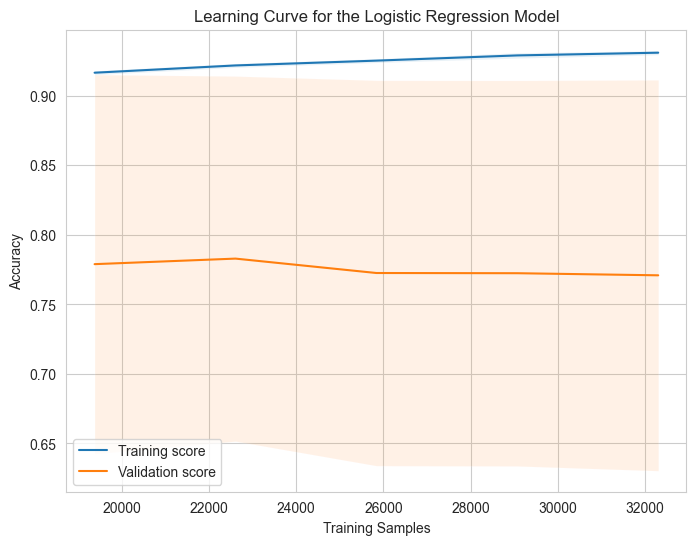

In [ ]:
if 'best_model' in locals() and 'X_resampled' in locals() and 'y_resampled' in locals():
    # Calculate learning curve data (Section 5.10.2, Figure 17 equivalent).
    # This function trains the model multiple times on subsets of the resampled data.
    # cv=CV_FOLDS_LC defines the number of folds for the internal cross-validation used
    # to generate training and validation scores at each training size.
    # train_sizes defines the proportions of the training set used.
    # random_state ensures reproducibility of the internal data splits for the curve.

    train_sizes, train_scores, test_scores = learning_curve(
        best_model, # The trained model object to evaluate.
        X_resampled, y_resampled, # The full dataset after oversampling.
        cv=CV_FOLDS_LC, # Number of cross-validation folds for the learning curve calculation.
        scoring='accuracy', # The evaluation metric used (accuracy is standard for learning curves).
        n_jobs=-1, # Use all available cores for parallel processing to speed up calculation.
        train_sizes=np.linspace(0.1, 1.0, 10), # Evaluate performance at 10 different training set sizes, from 10% to 100%.
        random_state=RANDOM_STATE # Seed for reproducibility of internal data splits for the curve.
    )

    # Calculate the mean and standard deviation of the training and test scores across the folds.
    # These are used to plot the average performance and variability (shaded area) at each training size.
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve (Section 5.10.2, Figure 17 equivalent).
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Validation score')

    # Plot the shaded area representing the variability (standard deviation) around the mean scores.
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel('Training Samples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve for the Logistic Regression Model')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Model or resampled data not loaded. Please check previous cells.")

### 5.10.3 Ensuring Data Integrity (Correlation Analysis)

Examining the correlation between individual input features and the target variable helps to understand the relationship between them and can reveal potential issues like data leakage if a feature is too highly correlated with the target, inadvertently providing the answer. This analysis, discussed in Section 5.10.3 and presented in Table 10 of the thesis, shows the linear relationship strength (Pearson correlation coefficient) between each feature and the `ezafe_label`. Values closer to +1 or -1 indicate strong positive or negative linear correlation, respectively, while values near 0 indicate weak correlation.

In [ ]:
# Load the correlation matrix data with the target variable (Section 5.10.3, Table 10 equivalent).
# This file is generated by the lr_feature_engineering.py script, therefore has an extra feature, namely source_file, 
# which was added only during the error_analysis phase.

CORRELATION_MATRIX_CSV = "feature_correlation_matrix.csv"

if os.path.exists(CORRELATION_MATRIX_CSV):
    correlation_df = pd.read_csv(CORRELATION_MATRIX_CSV)
    print(f"Loaded correlation data from '{CORRELATION_MATRIX_CSV}'.")

    print("\nCorrelation between input features and the ezafe presence target variable (Section 5.10.3, Table 10 equivalent):")
    # Display the entire table using to_string() to ensure all rows and columns are visible.
    print(correlation_df.to_string())

else:
    print(f"Error: Correlation matrix file not found at '{CORRELATION_MATRIX_CSV}'.")
    print("Please ensure lr_feature_engineering.py was run and saved this file.")

Loaded correlation data from 'feature_correlation_matrix.csv'.

Correlation between input features and the ezafe presence target variable (Section 5.10.3, Table 10 equivalent):
                              Feature  Correlation with ezafe_label
0                         ezafe_label                      1.000000
1               dependent_deprel_case                      0.179584
2                  dependent_upos_ADP                      0.179447
3                dependent_deprel_det                      0.163980
4                  dependent_upos_DET                      0.161540
5               dependent_deprel_conj                      0.138244
6                 dependent_deprel_cc                      0.118985
7                dependent_upos_CCONJ                      0.118757
8             nominal_head_upos_PROPN                      0.054201
9             dependent_deprel_nummod                      0.052804
10               dependent_upos_SCONJ                      0.051224
11     

The correlation analysis (the table above) examines the linear relationship between the input features and the `ezafe_label` target variable. The correlation coefficients provide insight into how strongly each feature is associated with the presence or absence of ezafe. Values closer to +1 or -1 indicate a strong linear relationship, while values near 0 suggest a weak one.

Observing the correlation values, it is evident that no single feature exhibits a perfect correlation with the target variable (correlation coefficient equal to or close to 1 or -1). This outcome is essential for ensuring data integrity, as it indicates that the model must learn from the combined influence of multiple features rather than relying on a single feature that might inadvertently encode the target information (Section 5.10.3).

The specific numerical values and ranking of features in the correlation table produced by this notebook run (the output from the previous cell) show slight differences when compared to the correlation results reported in the thesis (Table 10). For instance, the strongest correlations and their ranking vary somewhat. This variation in specific numerical results, while not indicative of data leakage, is likely attributable to the later introduction of source_file (Table 11) as a new feature set (OHE) compared to the one used for generating the thesis results.

However, the general principle holds: no single feature is a perfect predictor, and the model must integrate information from various features to make predictions. The features identified in the table, such as dependency relations (`dependent_deprel`), part-of-speech tags (`dependent_upos`, `nominal_head_upos`), structural measures (`num_dependents_dependent`, `distance`), and source file information, all show some degree of association with the target, confirming their potential relevance for the classification task.


### 5.10.4 Random Label Shuffling

The random label shuffling test is a validation technique used to check if a model is learning actual patterns in the data or simply memorizing noise. The target variable labels in the training set are randomly shuffled, breaking any true relationship between features and labels. If a model trained on this shuffled data still achieves high accuracy on the original test set, it suggests that the model might be learning from unintended clues or biases in the data itself rather than the true feature-label relationship. A low accuracy (close to random chance) with shuffled labels, however, indicates that the model is indeed learning from meaningful patterns (Section 5.10.4).

In [ ]:
if 'best_model' in locals() and 'X_train' in locals() and 'y_train' in locals() and 'X_test' in locals() and 'y_test' in locals():
    # Perform the random label shuffling test (Section 5.10.4).
    # Shuffle the training labels (y_train) while keeping the corresponding features (X_train) in their original order.
    y_train_shuffled = shuffle(y_train, random_state=RANDOM_STATE) # Use the same random state for reproducibility of the shuffling.

    # Train a model again but this time on the shuffled data.
    # We use a model with the same type and configuration as the best model found during tuning.
    # Using 'liblinear' solver is often efficient for this quick test.
    # Ensure random_state is set here as well for reproducibility of the training process itself.
    shuffled_model = LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear', random_state=RANDOM_STATE)

    print("Training a Logistic Regression model on shuffled labels...")
    try:
        # Fit the temporary model on the training features with the shuffled labels.
        shuffled_model.fit(X_train, y_train_shuffled)

        # Evaluate the model trained on shuffled data by making predictions on the *original* test set features (X_test)
        # and comparing them to the *original* test set labels (y_test).
        y_pred_shuffled = shuffled_model.predict(X_test)
        accuracy_shuffled = accuracy_score(y_test, y_pred_shuffled)

        print(f"Accuracy with shuffled training labels: {accuracy_shuffled:.4f}")

        # Compare this accuracy to the accuracy achieved by the original, best model on the original test set.
        y_pred_true = best_model.predict(X_test)
        accuracy_true = accuracy_score(y_test, y_pred_true)
        print(f"Accuracy with original training labels (from best_model): {accuracy_true:.4f}")

    except ValueError as e:
        print(f"Error during model training with shuffled labels: {e}")
        print("This might happen if the shuffled data distribution causes issues for the solver.")
else:
    print("Model or training/test data not loaded. Please check previous cells.")

Training a Logistic Regression model on shuffled labels...
Accuracy with shuffled training labels: 0.6694
Accuracy with original training labels (from best_model): 0.9310


### 5.10.5 Error Analysis

Analyzing instances where the model made incorrect predictions (misclassifications) provides valuable insight into the types of linguistic features or structural characteristics that are challenging for the model and contribute to errors. This involves identifying the misclassified cases in the test set and examining their features. By calculating the mean values of features across all misclassified instances, we can identify which features tend to have particular values or ranges when the model makes mistakes (Section 5.10.5). The percentage contribution of each feature to the total misclassification, based on the magnitude of its mean value in misclassified cases, helps highlight the most influential features in error patterns (Section 5.10.5, Equation 5, Table B5).

In [ ]:
# Ensure y_test and y_pred are defined before proceeding
if 'y_test' in locals() and 'y_pred' in locals() and 'X_test' in locals():
    # Identify misclassified instances in the test set (Section 5.10.5).
    # Create a DataFrame of the test set results for easy comparison of actual vs. predicted labels.
    test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

    # Find the indices of instances where the predicted label does not match the actual label.
    misclassified_indices = test_results[test_results['Actual'] != test_results['Predicted']].index

    print(f"Number of misclassified instances in the test set: {len(misclassified_indices)}")

    # Compute the mean feature values for the misclassified cases (Section 5.10.5).
    # I use the X_test DataFrame, which contains the scaled feature values used by the model.
    # This provides insight into the average feature profile of cases that the model struggled with.
    if not misclassified_indices.empty:
        X_test_misclassified = X_test.loc[misclassified_indices]
        misclassified_features_mean = X_test_misclassified.mean()

        # Calculate the percentage contribution of each feature to misclassification (Section 5.10.5, Equation 5).
        # This metric is based on the absolute mean feature values in the misclassified set.
        total_abs_mean = misclassified_features_mean.abs().sum()

        if total_abs_mean == 0:
             print("Cannot calculate percentage contribution: Sum of absolute mean feature values is zero.")
             misclassified_features_percent = pd.Series(0, index=misclassified_features_mean.index)
        else:
            # Calculate percentage contribution for each feature based on its absolute mean value.
            misclassified_features_percent = (misclassified_features_mean.abs() / total_abs_mean) * 100
            # Normalize the percentages to sum exactly to 100% in case of minor floating-point inaccuracies.
            misclassified_features_percent = (misclassified_features_percent / misclassified_features_percent.sum()) * 100


        # Create a DataFrame to display the mean feature values and their percentage contributions to misclassification.
        # This serves as the equivalent of Table B5 in the thesis.
        misclassified_analysis_df = pd.DataFrame({
            "Mean Feature Value (Misclassified)": misclassified_features_mean,
            "Percentage Contribution (%)": misclassified_features_percent
        })

        # Sort the DataFrame by absolute percentage contribution in descending order for easier interpretation.
        misclassified_analysis_df_sorted = misclassified_analysis_df.reindex(misclassified_features_percent.abs().sort_values(ascending=False).index)

        print("\nTop Features Associated with Misclassification (Analysis on Scaled Features, Section 5.10.5, Table B5 equivalent):")
        # Display the entire sorted table.
        print(misclassified_analysis_df_sorted.to_string())

    else:
        print("No misclassified instances to analyze.")
else:
    print("Test labels (y_test), predicted labels (y_pred), or test features (X_test) not defined. Please check previous cells.")

Number of misclassified instances in the test set: 836

Top Features Associated with Misclassification (Analysis on Scaled Features, Section 5.10.5, Table B5 equivalent):
                                   Mean Feature Value (Misclassified)  Percentage Contribution (%)
num_dependents_dependent                                     1.610048                    24.983759
distance                                                     1.231459                    19.109049
position_numeric                                             0.726077                    11.266821
dependent_deprel_nmod                                        0.398325                     6.180974
dependent_upos_NOUN                                          0.383971                     5.958237
source_file_GBd_TD1.conllu                                   0.368421                     5.716937
source_file_Dk5_B.conllu                                     0.174641                     2.709977
dependent_deprel_acl:relcl           

## Summary and Conclusion

This notebook presents a detailed analysis of the Logistic Regression model trained to identify the presence of ezafe in Middle Persian nominal phrases, as described in Sections 5.9 and 5.10 of the thesis. By applying computational methods to an annotated corpus, the study aimed to uncover patterns influencing ezafe usage.

The model achieved high overall performance metrics on the test set (referencing output from Cell 5), including accuracy of approximately **0.93**, balanced precision and recall scores, and high AUC values (referencing Figure 16 equivalent and output from Cell 10), indicating a strong ability to distinguish between nominal phrases with and without ezafe.

Evaluation procedures confirmed the model's robustness. The learning curve suggested good generalization with training and validation scores converging (referencing Figure 17 equivalent and output from Cell 12). Correlation analysis indicated that no single feature perfectly predicted the target (referencing Table 10 equivalent and output from Cell 14), and the random label shuffling test demonstrated that the model learned from actual feature-label relationships rather than noise (referencing output from Cell 17).

Analysis of feature importance (as discussed in Section 5.11, based on coefficients from Section 5.4.6) and misclassification errors (Section 5.10.5, referencing output from Cell 20) highlighted key linguistic features influencing the model's decisions. Structural and complexity indicators, such as the number of dependents of the dependent, distance between the head and the dependent, and the encoded position, were particularly prominent in both successful predictions and error patterns. Dependency relations and part-of-speech tags of the dependent, along with source file information, also played relevant roles. The error analysis provided insight into the specific feature profiles associated with misclassifications, pointing to constructions where the model struggled to generalize.

These empirical findings offer quantitative support for understanding the syntactic conditioning of ezafe in Middle Persian. The results emphasize the importance of complexity features in predicting ezafe presence and absence, reflecting the role of ezafe as a syntactic linker within nominal phrases. The influence of source file information suggests potential text-specific variations in ezafe usage. Further discussion of the results and especially in comparison to the results from the other model can be found in the Discussion and Conclusion chapter of the thesis (Chapter 7).

It is noted that the specific numerical results obtained in this notebook execution may show minor variations compared to figures and tables presented in the thesis (Sections 5.9, 5.10, Tables 8, 10, 11, B5, Figures 15, 16, 17). As discussed previously (referencing Cell 1 and other analysis sections), these differences are attributed to a late introduction of a new feature, namely source_File. However, the methodology implemented in the code is consistent with that described in the thesis, and the overall patterns and conclusions drawn regarding the model's performance and linguistic insights are aligned with the thesis findings.

In conclusion, the Logistic Regression model successfully identified influential features for ezafe identification, providing a data-driven perspective that complements traditional linguistic analysis. This computational approach contributes to a deeper understanding of Middle Persian syntax and demonstrates the applicability of machine learning techniques to historical linguistic phenomena, supporting the broader discussion in Chapter 7 of the thesis.